In [ ]:
import torch
from torch import nn, Tensor
import numpy as np
from torchvision.utils import save_image

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#1. Dataset

In [ ]:
import torchvision

img_size = 32

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

images = torchvision.datasets.MNIST(root='./mnist_data', train=True,
                                    download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 168864176.81it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 35071133.13it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 60031695.05it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5474289.88it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
BATCH_SIZE = 64
dataloader = torch.utils.data.DataLoader(images, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
next(iter(dataloader))

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         ...,
 
 
         [[[-1., -1., -1.,  ..., -

# 2. Model

In [ ]:
channels = 1
img_shape = (channels, img_size, img_size)
latent_dim = 100

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            #nn.BatchNorm1d(128),
            #nn.LeakyReLU(0.2, inplace=True),
            #nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, x):
        img = self.model(x)
        img = img.view(img.size(0), *img_shape)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        x = img.view(img.size(0), -1)
        x = self.model(x)
        return x


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 3. Training


In [ ]:
import os
os.makedirs("images", exist_ok=True)

save_interval = 10

In [ ]:
EPOCHS = 200

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

hist = {
    "train_G_loss":[],
    "train_D_loss":[]
}

for epoch in range(EPOCHS):
    running_G_loss = 0.0
    running_D_loss = 0.0

    for i, (imgs, _) in enumerate(dataloader):

        real_imgs = imgs.to(device)
        real_labels = torch.ones(imgs.shape[0], 1).to(device)
        fake_labels = torch.zeros(imgs.shape[0], 1).to(device)

        #----Train Generator----
        optimizer_G.zero_grad()

        # Noise input for Generator
        z = torch.randn((imgs.shape[0], latent_dim)).to(device)

        gen_imgs = generator(z)
        G_loss = criterion(discriminator(gen_imgs), real_labels)
        running_G_loss += G_loss.item()

        G_loss.backward()
        optimizer_G.step()

        #----Train Discriminator----
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake_labels)
        # detach for creating a copy, and do not update gradients of G
        D_loss = (real_loss + fake_loss) / 2
        running_D_loss += D_loss.item()

        D_loss.backward()
        optimizer_D.step()

    epoch_G_loss = running_G_loss / len(dataloader)
    epoch_D_loss = running_D_loss / len(dataloader)

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train G Loss: {epoch_G_loss:.4f}, Train D Loss: {epoch_D_loss:.4f}")

    hist["train_G_loss"].append(epoch_G_loss)
    hist["train_D_loss"].append(epoch_D_loss)

    if epoch % save_interval == 0:
        save_image(gen_imgs.data[:25], f"images/epoch_{epoch}.png", nrow=5, normalize=True)

Epoch [1/200], Train G Loss: 9.2706, Train D Loss: 0.0501
Epoch [2/200], Train G Loss: 7.1514, Train D Loss: 0.0589
Epoch [3/200], Train G Loss: 6.8083, Train D Loss: 0.0360
Epoch [4/200], Train G Loss: 6.9454, Train D Loss: 0.0539
Epoch [5/200], Train G Loss: 6.8472, Train D Loss: 0.0626
Epoch [6/200], Train G Loss: 6.7131, Train D Loss: 0.0722
Epoch [7/200], Train G Loss: 6.0395, Train D Loss: 0.1042
Epoch [8/200], Train G Loss: 5.7264, Train D Loss: 0.1021
Epoch [9/200], Train G Loss: 5.8611, Train D Loss: 0.0998
Epoch [10/200], Train G Loss: 5.7438, Train D Loss: 0.1088
Epoch [11/200], Train G Loss: 5.3954, Train D Loss: 0.1159
Epoch [12/200], Train G Loss: 5.2642, Train D Loss: 0.1328
Epoch [13/200], Train G Loss: 4.7555, Train D Loss: 0.1529
Epoch [14/200], Train G Loss: 4.6534, Train D Loss: 0.1568
Epoch [15/200], Train G Loss: 4.2824, Train D Loss: 0.1653
Epoch [16/200], Train G Loss: 4.3738, Train D Loss: 0.1807
Epoch [17/200], Train G Loss: 4.0368, Train D Loss: 0.1953
Epoch 

# 4. Testing

In [ ]:
from PIL import Image

In [ ]:
input = torch.randn(3, latent_dim)

In [ ]:
with torch.no_grad():
    imgs = generator(input.to(device))

In [ ]:
imgs

tensor([[[[-0.9998, -0.9983, -0.9999,  ..., -0.9998, -0.9999, -0.9994],
          [-0.9997, -0.9990, -0.9982,  ..., -0.9991, -0.9990, -0.9994],
          [-0.9998, -0.9999, -0.9998,  ..., -0.9990, -0.9981, -0.9997],
          ...,
          [-0.9998, -0.9947, -0.9994,  ..., -0.9999, -0.9994, -0.9997],
          [-0.9999, -0.9998, -0.9984,  ..., -0.9989, -0.9987, -0.9991],
          [-0.9999, -0.9991, -0.9990,  ..., -0.9983, -0.9993, -0.9981]]],


        [[[-0.9983, -0.9996, -0.9996,  ..., -0.9988, -0.9996, -0.9984],
          [-0.9999, -0.9994, -0.9990,  ..., -0.9990, -0.9998, -0.9977],
          [-0.9998, -0.9995, -0.9952,  ..., -0.9992, -0.9996, -0.9998],
          ...,
          [-0.9991, -0.9984, -0.9999,  ..., -0.9990, -0.9988, -0.9992],
          [-0.9998, -0.9993, -0.9997,  ..., -0.9979, -0.9986, -0.9996],
          [-0.9991, -0.9984, -0.9978,  ..., -0.9999, -0.9996, -0.9998]]],


        [[[-1.0000, -1.0000, -0.9998,  ..., -0.9999, -0.9999, -1.0000],
          [-1.0000, -1.000

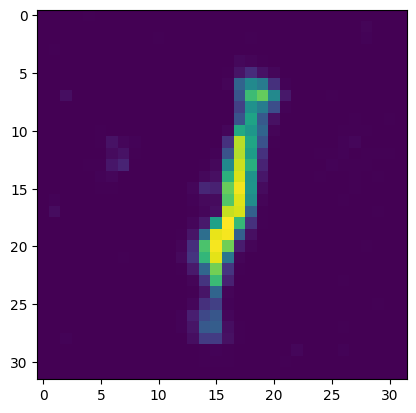

In [ ]:
import matplotlib.pyplot as plt
image_tensor = ((imgs[0] + 1) / 2).cpu()


plt.imshow(image_tensor.permute(1, 2, 0).detach().numpy())
plt.show()